# Build a co-authorship Network

The nodes are authors and the edges are co-authorship (undirected). The width of the edge is the frequency of co-authoring. Other modification could be: 
* color of edge is the year of publication
* nodes are colored by publication
* nodes are sized by centrality, tenure of authors (if we would have that)

In [36]:
import scraper as sc
import pandas as pd
from collections import defaultdict

import networkx as nx

import pickle as pk
import numpy as np
from scipy import sparse as sp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
retmax = 10 
email = 'kbohlec@gmail.com'

In [38]:
def make_query(term, year):
    return '({}[Title/Abstract]) AND \
({}[Date - Publication])'\
.format(term, year)

In [39]:
make_query('parkinson\'s', 2016)

"(parkinson's[Title/Abstract]) AND (2016[Date - Publication])"

In [40]:
# rough, should probably be using a defaultdict here
for i, n in enumerate(range(2000,2019,1)):
    new_keys = range(i*retmax, (i+1)*retmax)
    query = make_query('parkinson\'s', n)
    ap = sc.ArticleParser(retmax, email)
    raw_dict = ap.find_term(query)
    articles = ap.fetch_info(raw_dict['IdList'])
    if i == 0:
        parsed_dict = ap.parse_info(articles)
    else:
        n_parsed_dict = ap.parse_info(articles)
        for k in n_parsed_dict.keys():
            parsed_dict[new_keys[k]] = n_parsed_dict[k] # add articles from the next year behind the current  

There are no citations for article 0

There are no citations for article 1

There are no citations for article 2

There are no citations for article 3

There's no abstract for article 3

There's no abstract for article 4

There's no author info for article 5

There are no citations for article 5

There are no citations for article 6

There are no citations for article 7

There are no citations for article 9

There are no citations for article 0

There are no citations for article 1

There are no citations for article 2

There are no citations for article 4

There are no citations for article 6

There are no citations for article 7

There are no citations for article 8

There are no citations for article 9

There are no citations for article 0

There are no citations for article 2

There are no citations for article 3

There are no citations for article 4

There are no citations for article 5

There are no citations for article 6

There are no citations for article 7

There are no citat

In [41]:
df = pd.DataFrame.from_dict(parsed_dict, orient = 'index')
df.date = pd.to_datetime(df.date)
df = df[df.abstract != ''].sort_values(by='date', 
                                       ascending=0)\
                          .reset_index(drop=True)
df.head()

,title,date,authors,published in,citations,abstract
0,"Parkinson disease, temporomandibular disorders...",2018-07-19,"Merel Verhoeff, Frank Lobbezoo, Peter Wetselaa...",Journal of oral rehabilitation,,Even though bruxism and Parkinson's disease (P...
1,Mode-Selective Raman Imaging of Dopamine-Human...,2018-07-19,"Achut Prasad Silwal, H Peter Lu",ACS chemical neuroscience,,Dopamine (DA) is the catecholamine neurotransm...
2,A minimally invasive neurostimulation method f...,2018-07-19,"Malbor Asllani, Paul Expert, Timoteo Carletti",PLoS computational biology,,Many collective phenomena in Nature emerge fro...
3,Ubiquitination of alpha-synuclein filaments by...,2018-07-18,"Thomas Mund, Masami Masuda-Suzukake, Michel Go...",PloS one,,"Alpha-synuclein can form beta-sheet filaments,..."
4,Fibroblast Growth Factor 9 Suppresses Striatal...,2018-07-18,"Issa Olakunle Yusuf, Pei-Hsun Cheng, Hsiu-Mei ...",Cellular physiology and biochemistry : interna...,,Huntington's disease (HD) is a heritable neuro...


## Create network

The authors are listed in one cell separated by coma. *Assumption: Author names are correct. Each spelling of a name is a unique author. This is often the wrong assumption to have*.
Check about [*Author Name Disambiguation (AND)*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5887226/).
This [Kaggle Notebook by Yasmin](https://www.kaggle.com/ykhorramz/network-viz-nips-15-co-authorship-network/notebook) is pretty useful. 

In [42]:
plt.style.use('seaborn-whitegrid')

title_font = {'size':'18', 'color':'black', 'verticalalignment':'bottom',  'fontstyle':'bold'} 
axis_font = { 'size':'14'}

## Create a data frame with title - authors.

Author need to be split at comma

In [43]:
df.head(2)

,title,date,authors,published in,citations,abstract
0,"Parkinson disease, temporomandibular disorders...",2018-07-19,"Merel Verhoeff, Frank Lobbezoo, Peter Wetselaa...",Journal of oral rehabilitation,,Even though bruxism and Parkinson's disease (P...
1,Mode-Selective Raman Imaging of Dopamine-Human...,2018-07-19,"Achut Prasad Silwal, H Peter Lu",ACS chemical neuroscience,,Dopamine (DA) is the catecholamine neurotransm...


In [44]:
# https://gist.github.com/jlln/338b4b0b55bd6984f883

def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [45]:
#splitDataFrameList(df, df['authors'], ',') 

In [46]:
df_split = splitDataFrameList(df, 'authors', ',')

In [47]:
df_split[0:5]

,abstract,authors,citations,date,published in,title
0,Even though bruxism and Parkinson's disease (P...,Merel Verhoeff,,2018-07-19,Journal of oral rehabilitation,"Parkinson disease, temporomandibular disorders..."
1,Even though bruxism and Parkinson's disease (P...,Frank Lobbezoo,,2018-07-19,Journal of oral rehabilitation,"Parkinson disease, temporomandibular disorders..."
2,Even though bruxism and Parkinson's disease (P...,Peter Wetselaar,,2018-07-19,Journal of oral rehabilitation,"Parkinson disease, temporomandibular disorders..."
3,Even though bruxism and Parkinson's disease (P...,Ghizlane Aarab,,2018-07-19,Journal of oral rehabilitation,"Parkinson disease, temporomandibular disorders..."
4,Even though bruxism and Parkinson's disease (P...,Michail Koutris,,2018-07-19,Journal of oral rehabilitation,"Parkinson disease, temporomandibular disorders..."


The columns authors - titles in are the basis for the bipartite graph. It's in an edgelist format. Create a bipartite matrix with authors as rows and titles as columns. Then do a 1 mode projection

In [179]:
B=nx.Graph()
B.add_nodes_from(df_split['authors'],bipartite= 'authors')
B.add_nodes_from(df_split['title'],bipartite='title')

In [180]:
B.add_edges_from(
    [(row['authors'], row['title']) for idx, row in df_split.iterrows()])

In [172]:
#print(B.edges(data=True))

stupid graph, but testing...

/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:


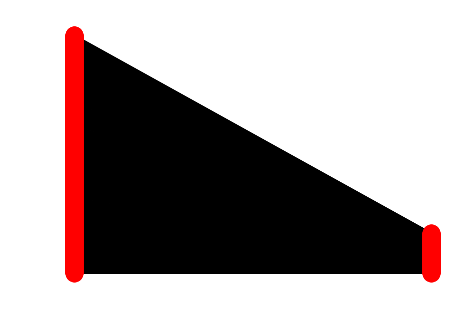

In [124]:
pos = {node:[0, i] for i,node in enumerate(df_split['authors'])}
pos.update({node:[1, i] for i,node in enumerate(df['title'])})
nx.draw(B, pos, with_labels=False)
for p in pos:  # raise text positions
    pos[p][1] += 0.25

plt.show()

## one mode projection
[Data camp tutorial](https://s3.amazonaws.com/assets.datacamp.com/production/course_4015/slides/ch2_slides.pdf)

In [181]:
auth_nodes = [n for n in B.nodes() if B.node[n] ['bipartite'] == 'authors'] 

In [182]:
auth_nodes[0]

'Merel Verhoeff'

In [183]:
G_aut = nx.bipartite.projected_graph(B, auth_nodes) 

## Create group attribute based on publication

In [256]:
authors = df_split['authors']
pub = df_split['published in']

In [257]:
group_attr = list(zip(authors, pub))

In [258]:
group_attr_dict = dict(set(sorted(group_attr)))

In [261]:
# set nodes attributes
nx.set_node_attributes(G_aut, "authors", group_attr_dict)

/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


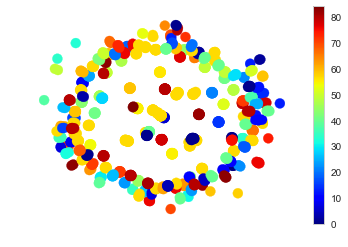

In [263]:
import matplotlib.pyplot as plt
# create number for each group to allow use of colormap
from itertools import count
# get unique groups
groups = set(nx.get_node_attributes(G_aut,'authors').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G_aut.nodes()
colors = [mapping[G_aut.node[n]['authors']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(G_aut) # different layout algorithm ? 
ec = nx.draw_networkx_edges(G_aut, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G_aut, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

## Compute network centrality measures to add to authors dataframe

In [267]:
'''number of co-authors per member '''
node_deg = nx.degree(G_aut) 

'''normalized number of co-authors ( with what fraction of NIPS authors he wrote a paper) '''
deg_cent = nx.degree_centrality(G_aut) 

'''fraction of the number of times the author appears on the path connecting two other authors '''
bet_cent = nx.betweenness_centrality(G_aut)

In [268]:
# set nodes attributes
nx.set_node_attributes(G_aut, "degree", node_deg)
nx.set_node_attributes(G_aut, "degree_norm", deg_cent)
nx.set_node_attributes(G_aut, "betweeness", bet_cent)

In [276]:
# sns.countplot(node_deg) how to easily plot the values without transforming it ?

Long tail degree distribution. Normal for social networks

In [277]:
print("The network has {} edges, {} authors, and a density of {:.3}.".format(G_aut.number_of_edges(), 
                                                                                       G_aut.number_of_nodes(), 
                                                                                       nx.density(G_aut)))

The network has 4300 edges, 1053 authors, and a density of 0.00776.
